In [1]:
from client_side import *

config = connect_db(db_type='postgres', host='eda-client', database='test_cli', user='postgres', password='postgres', port='5432', interval=10)
visualize(config)

Configuration data sent successfully.


Row(sizing_mode='stretch_width')
    [0] Column(width=350)
        [0] Markdown(str, sizing_mode='stretch_width')
        [1] Accordion(sizing_mode='stretch_width')
            [0] Tabulator(formatters={'key': BooleanFormatter(i...}, name="<i class='fa f..., show_index=False, sizing_mode='stretch_width', value=              ...)
            [1] Tabulator(formatters={'key': BooleanFormatter(i...}, name="<i class='fa f..., show_index=False, sizing_mode='stretch_width', value=              ...)
            [2] Tabulator(formatters={'key': BooleanFormatter(i...}, name="<i class='fa f..., show_index=False, sizing_mode='stretch_width', value=              ...)
            [3] Tabulator(formatters={'key': BooleanFormatter(i...}, name="<i class='fa f..., show_index=False, sizing_mode='stretch_width', value=              ...)
            [4] Tabulator(formatters={'key': BooleanFormatter(i...}, name="<i class='fa f..., show_index=False, sizing_mode='stretch_width', value=       column  ...)
            [5] Tabulator(formatters={'key': BooleanFormatter(i...}, name="<i class='fa f..., show_index=False, sizing_mode='stretch_width', value=              ...)
            [6] Tabulator(formatters={'key': BooleanFormatter(i...}, name="<i class='fa f..., show_index=False, sizing_mode='stretch_width', value=              ...)
            [7] Tabulator(formatters={'key': BooleanFormatter(i...}, name="<i class='fa f..., show_index=False, sizing_mode='stretch_width', value=             c...)
            [8] Tabulator(formatters={'key': BooleanFormatter(i...}, name="<i class='fa f..., show_index=False, sizing_mode='stretch_width', value=              ...)
            [9] Tabulator(formatters={'key': BooleanFormatter(i...}, name="<i class='fa f..., show_index=False, sizing_mode='stretch_width', value=              ...)
    [1] Column(sizing_mode='stretch_width')
        [0] Markdown(str, sizing_mode='stretch_width')
        [1] Row(sizing_mode='stretch_width')
            [0] TextInput(name='Title', placeholder='Enter a string f..., width=300)
            [1] Select(name='Tables', options=['database_statistics', ...], value='database_statistics', width=300)
            [2] Column(sizing_mode='stretch_width')
                [0] Select(name='Time range', options={'Last 30 minutes': '30 mi...}, value='30 minutes', width=300)
                [1] DatetimeRangePicker(disabled=True, value=(datetime.datetime(2023, ..., width=300)
            [3] Select(name='Auto refresh', options={'Off': 'None', ...}, value='None', width=300)
        [2] Card(title='Task', width=1200)
            [0] Row(sizing_mode='stretch_width')
                [0] Column(css_classes=['task_box'], sizing_mode='stretch_width')
                    [0] Row(sizing_mode='stretch_width')
                        [0] Select(name='Task', options=['Choose a task', ...], value='Choose a task', width=300)
                    [1] Row(sizing_mode='stretch_width')
                    [2] Row(sizing_mode='stretch_width')
                [1] Button(name='Add task', width=100)
        [3] Card(title='Split', width=1200)
            [0] Row(sizing_mode='stretch_width')
                [0] Select(name='Split', options=['None', 'column', ...], value='None', width=300)
                [1] Select(name='Split basis', width=300)
        [4] Button(name='Draw', width=100)

In [2]:
collect_performance_data(config)

Performance data is being collected.


{'db_type': 'postgres',
 'db_host': 'eda-client',
 'db_name': 'test_cli',
 'db_user': 'postgres',
 'db_password': 'postgres',
 'db_port': '5432',
 'interval': 10}

ValueError: 
    Invalid value of type 'builtins.str' received for the 'color' property of scatter.marker
        Received value: 'positive'

    The 'color' property is a color and may be specified as:
      - A hex string (e.g. '#ff0000')
      - An rgb/rgba string (e.g. 'rgb(255,0,0)')
      - An hsl/hsla string (e.g. 'hsl(0,100%,50%)')
      - An hsv/hsva string (e.g. 'hsv(0,100%,100%)')
      - A named CSS color:
            aliceblue, antiquewhite, aqua, aquamarine, azure,
            beige, bisque, black, blanchedalmond, blue,
            blueviolet, brown, burlywood, cadetblue,
            chartreuse, chocolate, coral, cornflowerblue,
            cornsilk, crimson, cyan, darkblue, darkcyan,
            darkgoldenrod, darkgray, darkgrey, darkgreen,
            darkkhaki, darkmagenta, darkolivegreen, darkorange,
            darkorchid, darkred, darksalmon, darkseagreen,
            darkslateblue, darkslategray, darkslategrey,
            darkturquoise, darkviolet, deeppink, deepskyblue,
            dimgray, dimgrey, dodgerblue, firebrick,
            floralwhite, forestgreen, fuchsia, gainsboro,
            ghostwhite, gold, goldenrod, gray, grey, green,
            greenyellow, honeydew, hotpink, indianred, indigo,
            ivory, khaki, lavender, lavenderblush, lawngreen,
            lemonchiffon, lightblue, lightcoral, lightcyan,
            lightgoldenrodyellow, lightgray, lightgrey,
            lightgreen, lightpink, lightsalmon, lightseagreen,
            lightskyblue, lightslategray, lightslategrey,
            lightsteelblue, lightyellow, lime, limegreen,
            linen, magenta, maroon, mediumaquamarine,
            mediumblue, mediumorchid, mediumpurple,
            mediumseagreen, mediumslateblue, mediumspringgreen,
            mediumturquoise, mediumvioletred, midnightblue,
            mintcream, mistyrose, moccasin, navajowhite, navy,
            oldlace, olive, olivedrab, orange, orangered,
            orchid, palegoldenrod, palegreen, paleturquoise,
            palevioletred, papayawhip, peachpuff, peru, pink,
            plum, powderblue, purple, red, rosybrown,
            royalblue, rebeccapurple, saddlebrown, salmon,
            sandybrown, seagreen, seashell, sienna, silver,
            skyblue, slateblue, slategray, slategrey, snow,
            springgreen, steelblue, tan, teal, thistle, tomato,
            turquoise, violet, wheat, white, whitesmoke,
            yellow, yellowgreen
      - A number that will be interpreted as a color
        according to scatter.marker.colorscale
      - A list or array of any of the above

In [12]:
df = load_all_metrics(config)

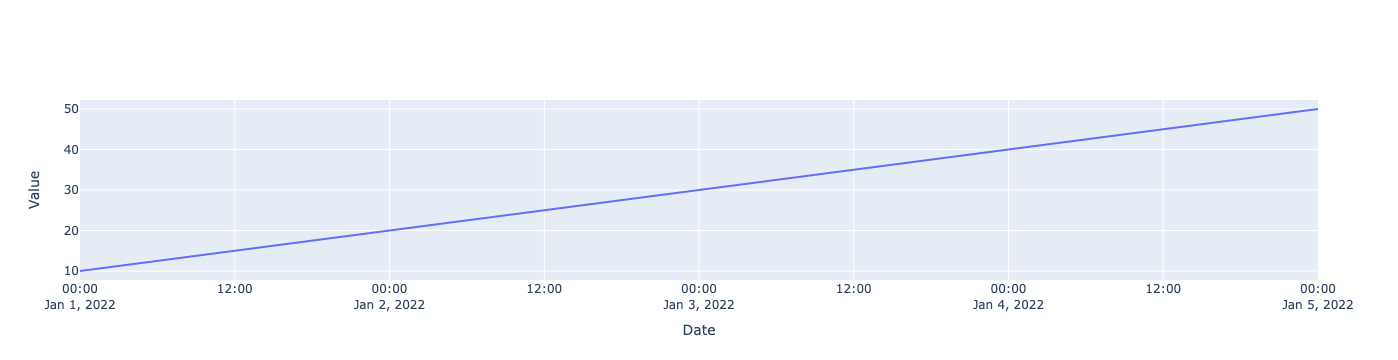

In [6]:
import pandas as pd
import plotly.graph_objects as go

# sample data
df = pd.DataFrame({'value': [10, 20, 30, 40, 50]}, 
                  index=pd.date_range(start='2022-01-01', periods=5, freq='D'))

# create figure using plotly.graph_objects
fig = go.Figure()

# add trace
fig.add_trace(go.Scatter(x=df.index, y=df['value'], mode='lines'))


# set x axis properties
fig.update_xaxes(title='Date')

# set y axis properties
fig.update_yaxes(title='Value')

# show figure
fig.show()


Error sending configuration data. Status code: 500


UnboundLocalError: local variable 'data' referenced before assignment

In [4]:
config

{'db_type': 'postgres',
 'db_host': 'eda-client',
 'db_name': 'test_cli',
 'db_user': 'postgres',
 'db_password': 'postgres',
 'db_port': '5432',
 'interval': 10}

In [13]:
df

,timestamp,buffers_alloc,checkpoints_timed,checkpoints_req,checkpoint_write_time,checkpoint_sync_time,buffers_checkpoint,buffers_clean,maxwritten_clean,buffers_backend,...,mem_active,mem_inactive,mem_buffers,mem_cached,mem_shared,mem_slab,disk_percent,disk_read_count,disk_write_count,disk_read_bytes
0,2023-05-01 22:51:44,1197,1790,2,12748.0,20.0,127,0,0,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-05-01 22:51:54,1197,1790,2,12748.0,20.0,127,0,0,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-05-01 23:00:43,1197,1792,2,12748.0,20.0,127,0,0,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-05-01 23:00:53,1197,1792,2,12748.0,20.0,127,0,0,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-05-01 23:01:03,1197,1792,2,12748.0,20.0,127,0,0,16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12233,2023-05-04 23:15:24,4922392,2655,69,1018788.0,174858.0,187981,200353,1920,13343033,...,54287237120,28271046656,2914390016,205053153280,404885504,145301852160,67.3,9647250,405885837,47098648576
12234,2023-05-04 23:15:30,4922392,2655,69,1018788.0,174858.0,187981,200353,1920,13343033,...,54180962304,28271038464,2914390016,205053423616,404877312,145301311488,67.3,9647250,405886407,47098648576
12235,2023-05-04 23:15:40,4922392,2655,69,1018788.0,174858.0,187981,200353,1920,13343033,...,54207107072,28271071232,2914390016,205053763584,404877312,145302216704,67.3,9647258,405887582,47098681344
12236,2023-05-04 23:15:50,4922392,2655,69,1018788.0,174858.0,187981,200353,1920,13343033,...,54352289792,28271079424,2914390016,205054046208,404885504,145303035904,67.3,9647286,405888434,47098796032
